In [1]:
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset
import cv2
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import itertools
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer,VisImage
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader,build_detection_train_loader
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators, verify_results
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetMapper
import copy
import torch
import warnings
from PIL import ImageFile
import itertools
import os
import numpy as np
from detectron2.structures import BoxMode


#### Dataset RockNet

In [2]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

lst1 = [15,16,16, 9, 10, 56, 23, 78, 5, 4, 9,9] 
lst2 = [9, 4, 5, 36, 47, 26, 10, 45, 87,16,16,9] 
print(intersection(lst1, lst2)) 

[4, 5, 9, 10, 16]


In [27]:
import os
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader

class VOCDataset(Dataset):
    def __init__(self, root_path="RockPascalVOC", mode="train"):
        
        
        if (mode in ["train", "val", "trainval", "test"]):
            self.data_path = root_path
        id_list_path = os.path.join(self.data_path, "ImageSets/Main/Rock_{}.txt".format(mode))
        liste1 = [id.strip("\n") for id in open(id_list_path)]
        liste1=[id[:-6] for id in liste1]
        path="RockNet/RockPascalVOC/JPEGImages"
        liste2=os.listdir(path)
        liste2=[id[:-4] for id in liste2]
        self.ids = intersection(liste1, liste2)
        self.classes = ['rock']
        self.num_classes = len(self.classes)
        self.num_images = len(self.ids)

    def __len__(self):
        return self.num_images
   
    def __getitem__(self, item):
        id = self.ids[item]
        image_path = os.path.join(self.data_path, "JPEGImages", "{}.jpg".format(id))
        if not os.path.isfile(image_path):
            
            image_path = os.path.join(self.data_path, "JPEGImages", "{}.JPG".format(id))
        if not os.path.isfile(image_path):
            image_path = os.path.join(self.data_path, "JPEGImages", "{}.png".format(id))
            
            
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height=image.shape[0]
        width=image.shape[1]
        image_xml_path = os.path.join(self.data_path, "Annotations", "{}.xml".format(id))
        annot = ET.parse(image_xml_path)
        objects = []
        dicts={}
        dicts["filename"]=image_path
        dicts["height"]=height
        dicts["width"]=width
        dicts["image_id"]=item
        dicts["image"]=image
        for obj in annot.findall('object'):
            xmin, xmax, ymin, ymax = [float(obj.find('bndbox').find(tag).text) - 1 for tag in
                                      ["xmin", "xmax", "ymin", "ymax"]]
            label = self.classes.index(obj.find('name').text.lower().strip())
            objects.append([xmin, ymin, xmax, ymax, label])
        
        dicts["annotations"]=np.array(objects)
        
        return dicts

In [29]:
training_set = VOCDataset(root_path='RockNet/RockPascalVOC', mode='train')
test_set = VOCDataset('RockNet/RockPascalVOC800', 'val')
print(len(training_set))
print(len(test_set))

88
4


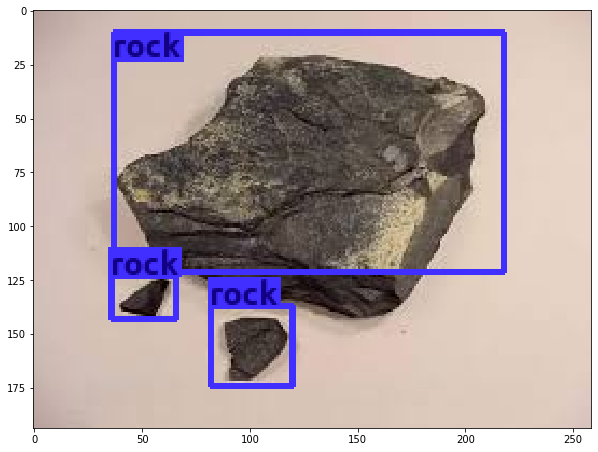

In [70]:
from bounding_box import bounding_box as bb
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
item=np.random.choice(len(training_set),1,replace=False)
dicts=training_set[item[0]]
image=dicts["image"]
label=dicts["annotations"]
fig,ax=plt.subplots(figsize=(10,10))
#ax.imshow(image.astype('uint8'))
for i in range(len(label)):
    data=label[i]
    xmin,ymin,xmax,ymax=data[0],data[1],data[2],data[3]
    #rect = mpatches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
    #                              fill=False, edgecolor='red', linewidth=2)
    bb.add(image, xmin, ymin, xmax, ymax, "rock", "red")
    #ax.add_patch(rect)
ax.imshow(image.astype('uint8'))   

In [6]:
def get_rock_dicts(mode):
    dataset=VOCDataset('RockNet/RockPascalVOC800',mode)
    dataset_dicts = []
    for item in range(len(dataset)):
        data=dataset[item]
        record = {}
        record["file_name"] = data["filename"]
        record["image_id"] = data["image_id"]
        record["height"] = data["height"]
        record["width"] = data["width"]
        annos=data["annotations"]
        objs = []
        for i in range(len(annos)):
            anno=annos[i]
            xmin = int(anno[0])
            ymin = int(anno[1])
            xmax = int(anno[2])
            ymax = int(anno[3])
            label=int(anno[4])

            poly = [
          (xmin, ymin), (xmax, ymin),
          (xmax, ymax), (xmin, ymax)
                                      ]
            poly = list(itertools.chain.from_iterable(poly))
            obj = {
                "bbox": [xmin,ymin,xmax,ymax],
                "bbox_mode": BoxMode.XYXY_ABS,
                 "segmentation": [poly],
                "category_id": label,
               "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [7]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    DatasetCatalog.register("rock_" + d, lambda d=d: get_rock_dicts(d))
    MetadataCatalog.get("rock_" + d).set(thing_classes=["rock"])
rock_metadata = MetadataCatalog.get("rock_train")

In [8]:
dataset_dicts = get_rock_dicts('val')

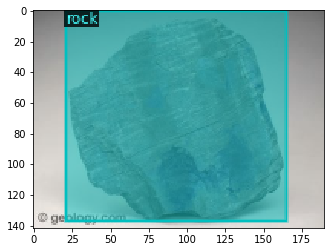

In [9]:
item=np.random.choice(len(dataset_dicts),1,replace=False)
d=dataset_dicts[item[0]]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=rock_metadata, scale=0.5)
vis = visualizer.draw_dataset_dict(d)
plt.imshow(vis.get_image()[:, :, ::-1])

# Custom mapper for data augmentation

In [10]:
class DatasetMapper:
    """
    A callable which takes a dataset dict in Detectron2 Dataset format,
    and map it into a format used by the model.

    This is a custom version of the DatasetMapper. The only different with Detectron2's 
    DatasetMapper is that we extract attributes from our dataset_dict. 
    """

    def __init__(self, cfg, is_train=True):
        if cfg.INPUT.CROP.ENABLED and is_train:
            self.crop_gen = T.RandomCrop(cfg.INPUT.CROP.TYPE, cfg.INPUT.CROP.SIZE)
            logging.getLogger(__name__).info("CropGen used in training: " + str(self.crop_gen))
        else:
            self.crop_gen = None
        
        self.tfm_gens = [T.Resize((640, 640)),
                         T.RandomBrightness(0.8, 1.8),
                         T.RandomContrast(0.6, 1.3),
                         T.RandomSaturation(0.8, 1.4),
                         T.RandomRotation(angle=[90, 90]),
                         T.RandomLighting(0.7),
                         T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
                         T.RandomCrop('relative_range', (0.4, 0.6))
                        ]

        # self.tfm_gens = utils.build_transform_gen(cfg, is_train)

        # fmt: off
        self.img_format     = cfg.INPUT.FORMAT
        self.mask_on        = cfg.MODEL.MASK_ON
        self.mask_format    = cfg.INPUT.MASK_FORMAT
        self.keypoint_on    = cfg.MODEL.KEYPOINT_ON
        self.load_proposals = cfg.MODEL.LOAD_PROPOSALS
        # fmt: on
        if self.keypoint_on and is_train:
            # Flip only makes sense in training
            self.keypoint_hflip_indices = utils.create_keypoint_hflip_indices(cfg.DATASETS.TRAIN)
        else:
            self.keypoint_hflip_indices = None

        if self.load_proposals:
            self.min_box_side_len = cfg.MODEL.PROPOSAL_GENERATOR.MIN_SIZE
            self.proposal_topk = (
                cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN
                if is_train
                else cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TEST
            )
        self.is_train = is_train

    def __call__(self, dataset_dict):
        """
        Args:
            dataset_dict (dict): Metadata of one image, in Detectron2 Dataset format.

        Returns:
            dict: a format that builtin models in detectron2 accept
        """
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        # USER: Write your own image loading if it's not from a file
        image = utils.read_image(dataset_dict["file_name"], format=self.img_format)
        utils.check_image_size(dataset_dict, image)

        if "annotations" not in dataset_dict:
            image, transforms = T.apply_transform_gens(
                ([self.crop_gen] if self.crop_gen else []) + self.tfm_gens, image
            )
        else:
            # Crop around an instance if there are instances in the image.
            # USER: Remove if you don't use cropping
            if self.crop_gen:
                crop_tfm = utils.gen_crop_transform_with_instance(
                    self.crop_gen.get_crop_size(image.shape[:2]),
                    image.shape[:2],
                    np.random.choice(dataset_dict["annotations"]),
                )
                image = crop_tfm.apply_image(image)
            image, transforms = T.apply_transform_gens(self.tfm_gens, image)
            if self.crop_gen:
                transforms = crop_tfm + transforms

        image_shape = image.shape[:2]  # h, w

        # Pytorch's dataloader is efficient on torch.Tensor due to shared-memory,
        # but not efficient on large generic data structures due to the use of pickle & mp.Queue.
        # Therefore it's important to use torch.Tensor.
        dataset_dict["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))

        # USER: Remove if you don't use pre-computed proposals.
        if self.load_proposals:
            utils.transform_proposals(
                dataset_dict, image_shape, transforms, self.min_box_side_len, self.proposal_topk
            )

        if not self.is_train:
            # USER: Modify this if you want to keep them for some reason.
            dataset_dict.pop("annotations", None)
            dataset_dict.pop("sem_seg_file_name", None)
            return dataset_dict

        if "annotations" in dataset_dict:
            # USER: Modify this if you want to keep them for some reason.
            for anno in dataset_dict["annotations"]:
                if not self.mask_on:
                    anno.pop("segmentation", None)
                if not self.keypoint_on:
                    anno.pop("keypoints", None)

            # USER: Implement additional transformations if you have other types of data
            annos = [
                utils.transform_instance_annotations(
                    obj, transforms, image_shape, keypoint_hflip_indices=self.keypoint_hflip_indices
                )
                for obj in dataset_dict.pop("annotations")
                if obj.get("iscrowd", 0) == 0
            ]
            instances = utils.annotations_to_instances(
                annos, image_shape, mask_format=self.mask_format
            )
            # Create a tight bounding box from masks, useful when image is cropped
            if self.crop_gen and instances.has("gt_masks"):
                instances.gt_boxes = instances.gt_masks.get_bounding_boxes()           
                          
            dataset_dict["instances"] = utils.filter_empty_instances(instances)
            
        return dataset_dict


In [11]:
class RockTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg))
    
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=DatasetMapper(cfg))

# Train

### configuration

In [12]:
MODEL_USE = 'fast_rcnn'
if MODEL_USE == 'faster_rcnn':
    MODEL_PATH = 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'
    WEIGHT_PATH = 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'
elif MODEL_USE == 'retinanet':
    MODEL_PATH = 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'
    WEIGHT_PATH = 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'
elif MODEL_USE == 'mask_rcnn':
    MODEL_PATH = 'COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml'
    WEIGHT_PATH = 'COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml'
elif MODEL_USE == 'cascade_mask_rcnn':
    MODEL_PATH = 'Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml'
    WEIGHT_PATH = 'Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml'

elif MODEL_USE == 'fast_rcnn':
    MODEL_PATH = 'COCO-Detection/fast_rcnn_R_50_FPN_1x.yaml'
    WEIGHT_PATH = 'COCO-Detection/fast_rcnn_R_50_FPN_1x.yaml'

def config_cfg():
    
    cfg = get_cfg()
    #cfg.MODEL.DEVICE='cpu'
    cfg.INPUT.MIN_SIZE_TRAIN=(640, 672, 704, 736, 768, 800)
    cfg.merge_from_file(model_zoo.get_config_file(MODEL_PATH))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(WEIGHT_PATH)  
    cfg.MODEL.RETINANET.NUM_CLASSES = training_set.num_classes
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = training_set.num_classes

    cfg.DATASETS.TRAIN = ("rock_train",)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 4

    cfg.SOLVER.IMS_PER_BATCH = 4
    cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR'
    cfg.SOLVER.BASE_LS = 0.0002
    cfg.SOLVER.MAX_ITER = 5000
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
        
    return cfg


In [14]:
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True
cfg = config_cfg()
trainer = RockTrainer(cfg)
#trainer=DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[08/02 21:33:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

KeyError: '0'

In [69]:
cfg = get_cfg()
#cfg.MODEL.DEVICE='cpu'
cfg.merge_from_file(model_zoo.get_config_file(MODEL_PATH))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = training_set.num_classes
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.RETINANET.NUM_CLASSES = training_set.num_classes
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = ("rock_val", )
predictor = DefaultPredictor(cfg)

In [57]:
def diff(dir1,dir2,save_folder):
    folder1=os.listdir(dir1)
    folder2=os.listdir(dir2)
    folder3 = [name for name in folder1 if name not in folder2]
    for name in folder3:
        try:
            im_path=os.path.join(dir1,name)
            im=cv2.imread(im_path)
            output_name=os.path.join(save_folder,name)
            cv2.imwrite(output_name,im)
        except:
            print(name,"corrompu")
            continue
    return True


In [58]:
dir1="Dataset"
dir2="RockNet/RockPascalVOC800/JPEGImages"
save_folder="TestROCK"
diff(dir1,dir2,save_folder)

.ipynb_checkpoints corrompu


True

In [67]:
import numpy as np
classes=["rock"]
def create_metric_file(input_folder,output_folder):
    print("Création en cours")
    #filenames=os.listdir(input_folder)
    filenames=os.listdir("RockNet/Object-Detection-Metrics/groundtruths")
    print("nombre d'images:",len(filenames))
    for i in range(len(filenames)):
        try:
            filename=filenames[i]
            try:
                image_path=os.path.join(input_folder,filename[:-4]+".jpg")
                im=cv2.imread(image_path)
                outputs = predictor(im)
                file=open(os.path.join(output_folder,filename[:-4]+".txt"),'w')
                cv2.imwrite(os.path.join("data",filename[:-4]+".jpg"),im)
            except:
                image_path=os.path.join(input_folder,filename[:-4]+".JPG")
                im=cv2.imread(image_path)
                outputs = predictor(im)
                file=open(os.path.join(output_folder,filename[:-4]+".txt"),'w')
                cv2.imwrite(os.path.join("data",filename[:-4]+".JPG"),im)
                
                
            instances=outputs["instances"].to("cpu")
            results=instances.get_fields()
            boxes=results["pred_boxes"]
            boxes=np.array(boxes.tensor)
            scores=results['scores']
            pred_classes=results["pred_classes"]
            for j in range(len(boxes)):
                xmin = int(boxes[j][0])
                ymin = int(boxes[j][1])
                xmax = int(boxes[j][2])
                ymax = int(boxes[j][3])
                file.write(classes[pred_classes[j]])
                file.write(" ")
                file.write(str(float(scores[j])))
                file.write(" ")
                file.write(str(int(xmin)))
                file.write(" ")
                file.write(str(int(ymin)))
                file.write(" ")
                file.write(str(int(xmax)))
                file.write(" ")
                file.write(str(int(ymax)))
                file.write("\n")
        except:
            print(filenames[i],"corrompu")
            continue
    print("Terminée")
                                

In [68]:
%%time
create_metric_file(input_folder="Dataset",output_folder="RockNet/metrics-fast_rcnn/detections")

Création en cours
nombre d'images: 290
Terminée
CPU times: user 8h 53min 38s, sys: 37min 36s, total: 9h 31min 15s
Wall time: 27min 10s


In [62]:
import pickle
import numpy as np
classes=["rock"]
colors = pickle.load(open("pallete", "rb"))
def predict(input_folder,save_folder):
    image_names=os.listdir(input_folder)
    for name in image_names:
        if name== ".ipynb_checkpoints":
            pass
        else:
            image_path=os.path.join(input_folder,name)
            #d=dataset_dicts[item]
            #im = cv2.imread(d["file_name"]) 
            #print(image_path)
            im=cv2.imread(image_path)
            outputs = predictor(im)
            instances=outputs["instances"].to("cpu")
            results=instances.get_fields()
            boxes=results["pred_boxes"]
            boxes=np.array(boxes.tensor)
            scores=results['scores']
            pred_classes=results["pred_classes"]
            for i in range(len(boxes)):
                xmin = int(boxes[i][0])
                ymin = int(boxes[i][1])
                xmax = int(boxes[i][2])
                ymax = int(boxes[i][3])
                #color = colors[pred_classes[i]]
                color=(0,255,0)
                cv2.rectangle(im, (xmin, ymin), (xmax, ymax), color, 4)
                text_size = cv2.getTextSize(classes[pred_classes[i]] + ' : %.2f' % scores[i], cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
                cv2.rectangle(im, (xmin, ymin), (xmin + text_size[0] + 3, ymin + text_size[1] + 4), color, -1)
                cv2.putText(
                        im, classes[pred_classes[i]] + ' : %.2f' % scores[i],
                        (xmin, ymin + text_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1,
                        (255, 255, 255), 2)
            #image_name=os.path.split()[1]
            outpout_name=name[:-4]+"prediction.jpg"
            #print(os.path.join(save_folder,outpout_name))
            cv2.imwrite(os.path.join(save_folder,outpout_name), im)


In [70]:
import time
t1=time.time()
predict(input_folder="Dataset",save_folder="RockNet/predictions-fast_rcnn")
t2=time.time()
t=t2-t1

In [32]:
t

60.271567821502686

In [42]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("rock_val", cfg, False, output_dir="./output")
val_loader = build_detection_test_loader(cfg, "rock_val")
#inference_on_dataset(trainer.model, val_loader, evaluator)
inference_on_dataset(predictor.model, val_loader, evaluator)

[04/16 14:49:27 d2.data.common]: Serializing 22 elements to byte tensors and concatenating them all ...
[04/16 14:49:27 d2.data.common]: Serialized dataset takes 0.01 MiB
[04/16 14:49:27 d2.evaluation.evaluator]: Start inference on 22 images
[04/16 14:49:29 d2.evaluation.evaluator]: Inference done 11/22. 0.1715 s / img. ETA=0:00:02
[04/16 14:49:31 d2.evaluation.evaluator]: Total inference time: 0:00:03.014262 (0.177310 s / img per device, on 1 devices)
[04/16 14:49:31 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.167382 s / img per device, on 1 devices)
[04/16 14:49:31 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/16 14:49:31 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[04/16 14:49:31 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE 

OrderedDict([('bbox',
              {'AP': 87.25579700827227,
               'AP50': 100.0,
               'AP75': 100.0,
               'APs': nan,
               'APm': nan,
               'APl': 87.25579700827227}),
             ('segm',
              {'AP': 90.35077793493636,
               'AP50': 100.0,
               'AP75': 100.0,
               'APs': nan,
               'APm': nan,
               'APl': 90.35077793493636})])